# Modelling Compressor Machine Using Deep Learning

### Objective

Modelling a compressor machine with dataset using deep learning.

### Import Library

In [1]:
# Utilities
import pandas as pd
import numpy as np
import math
import random
from collections import deque

# Deep Learning
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Visualization
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"  # static plotly

# Deep Learning Model of Compressor
# General data analysis/plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

### Dataset Input

In [2]:
# Load the dataset from the specified file path
file_path = './Compressor-_1_.xlsx'
df = pd.read_excel(file_path)

# Ensure 'HOUR' column values are zero-padded to two digits
df['HOUR'] = df['HOUR'].astype(str).apply(lambda x: x.zfill(2))

# Combine 'DATE' and 'HOUR' columns to create a new 'DATEHOUR' column
df['DATEHOUR'] = df['DATE'].dt.strftime('%d/%m/%Y').astype(str) + " " + df['HOUR'] + ":00"

# Convert 'DATEHOUR' column to datetime format
df['DATEHOUR'] = pd.to_datetime(df['DATEHOUR'], format='%d/%m/%Y %H:%M')

# Select relevant columns for further processing
df_2 = df[['DATEHOUR', 'DISCH_PRESS', 'DISCH_SUPERHEAT', 'DISCH_TEMP', 'SUCT_PRESS']]

# Remove rows where 'DISCH_PRESS' is 0
df_2 = df_2[df_2['DISCH_PRESS'] != 0.000000]

# Reset the index of the resulting dataframe
df_2 = df_2.reset_index(drop=True)

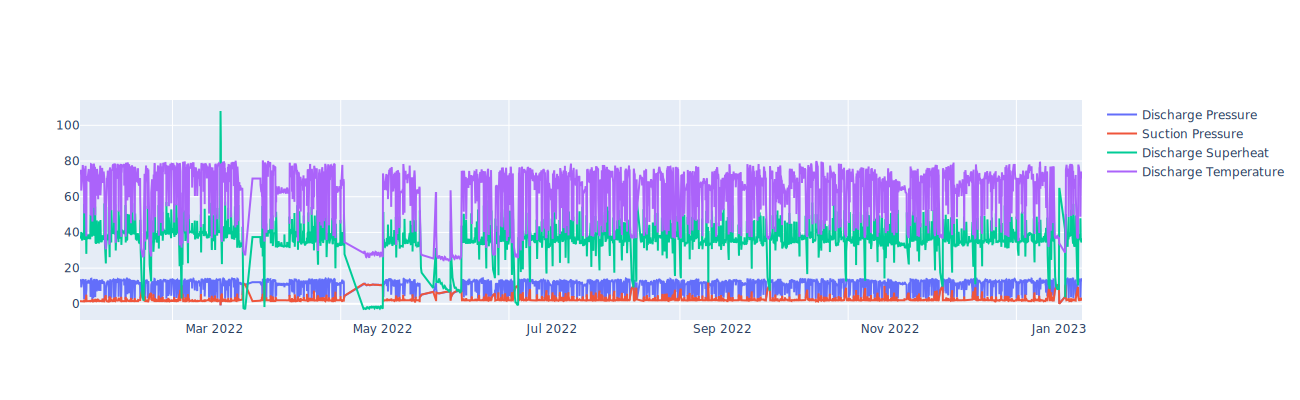

In [3]:
# Create a new plot using Plotly's Figure class with specified width and height
fig = go.Figure()

# Add a scatter plot for Discharge Pressure
fig.add_trace(go.Scatter(
    name="Discharge Pressure",
    x=df_2["DATEHOUR"], y=df_2["DISCH_PRESS"]
))

# Add a scatter plot for Suction Pressure
fig.add_trace(go.Scatter(
    name="Suction Pressure",
    x=df_2["DATEHOUR"], y=df_2["SUCT_PRESS"]
))

# Add a scatter plot for Discharge Superheat
fig.add_trace(go.Scatter(
    name="Discharge Superheat",
    x=df_2["DATEHOUR"], y=df_2["DISCH_SUPERHEAT"]
))

# Add a scatter plot for Discharge Temperature
fig.add_trace(go.Scatter(
    name="Discharge Temperature",
    x=df_2["DATEHOUR"], y=df_2["DISCH_TEMP"]
))

# Update the layout to specify a shorter height and wider width
fig.update_layout(height=400, width=1300)

# Update the x-axis settings to show grid lines and label every period
fig.update_xaxes(showgrid=True, ticklabelmode="period")

# Display the plot
fig.show()

In [4]:
# Initialize columns for percentage changes in compressor parameters
df_2['DISCH_PRESS_CHANGE'] = 0.0000
df_2['DISCH_SUPERHEAT_CHANGE'] = 0.0000
df_2['DISCH_TEMP_CHANGE'] = 0.0000
df_2['SUCT_PRESS_CHANGE'] = 0.0000

# Calculate percentage changes for each parameter and store them in respective columns
for i in range(len(df_2)):
    if i > 0:
        # Calculate percentage change for discharge pressure
        df_2['DISCH_PRESS_CHANGE'][i] = int(100 * (df_2['DISCH_PRESS'][i] - df_2['DISCH_PRESS'][i-1]) / df_2['DISCH_PRESS'][i-1])
        
        # Calculate percentage change for discharge superheat
        df_2['DISCH_SUPERHEAT_CHANGE'][i] = int(100 * (df_2['DISCH_SUPERHEAT'][i] - df_2['DISCH_SUPERHEAT'][i-1]) / df_2['DISCH_SUPERHEAT'][i-1])
        
        # Calculate percentage change for discharge temperature
        df_2['DISCH_TEMP_CHANGE'][i] = int(100 * (df_2['DISCH_TEMP'][i] - df_2['DISCH_TEMP'][i-1]) / df_2['DISCH_TEMP'][i-1])
        
        # Calculate percentage change for suction pressure
        df_2['SUCT_PRESS_CHANGE'][i] = int(100 * (df_2['SUCT_PRESS'][i] - df_2['SUCT_PRESS'][i-1]) / df_2['SUCT_PRESS'][i-1])

df_2.head()

,DATEHOUR,DISCH_PRESS,DISCH_SUPERHEAT,DISCH_TEMP,SUCT_PRESS,DISCH_PRESS_CHANGE,DISCH_SUPERHEAT_CHANGE,DISCH_TEMP_CHANGE,SUCT_PRESS_CHANGE
0,2022-01-26 11:00:00,13.061056,37.270040,73.736741,1.492004,0.0,0.0,0.0,0.0
1,2022-01-26 12:00:00,13.044837,37.103104,73.603123,1.490225,0.0,0.0,0.0,0.0
2,2022-01-26 13:00:00,13.186930,36.929701,73.643232,1.497291,1.0,0.0,0.0,0.0
3,2022-01-26 14:00:00,13.261127,37.044281,74.222097,1.492581,0.0,0.0,0.0,0.0
4,2022-01-26 15:00:00,13.039650,36.611514,73.087518,1.499338,-1.0,-1.0,-1.0,0.0


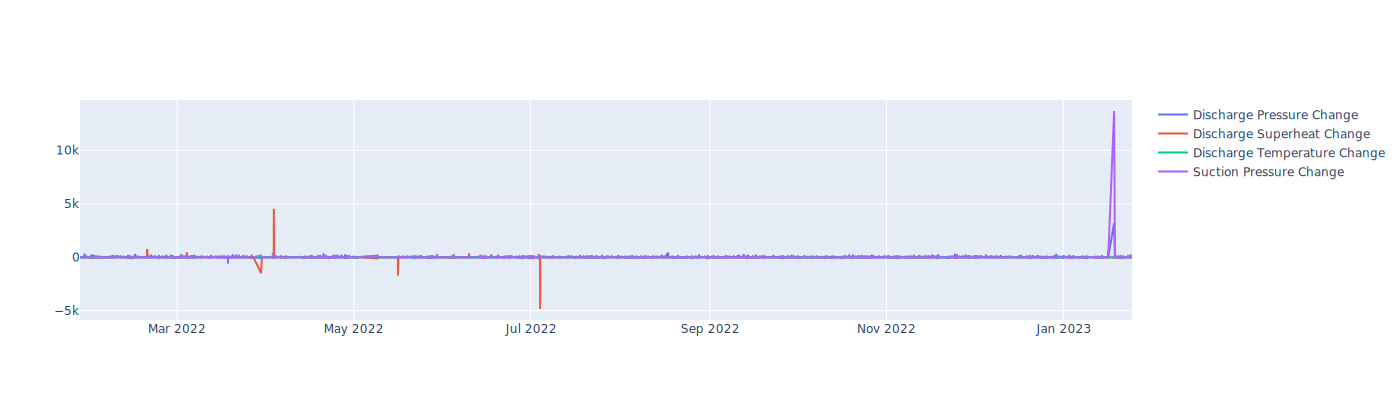

In [5]:
# Create a new plot using Plotly's Figure class with specified width and height
fig = go.Figure()

# Add scatter plots for percentage changes in compressor parameters
fig.add_trace(go.Scatter(
    name="Discharge Pressure Change",
    x=df_2["DATEHOUR"], y=df_2["DISCH_PRESS_CHANGE"]
))

fig.add_trace(go.Scatter(
    name="Discharge Superheat Change",
    x=df_2["DATEHOUR"], y=df_2["DISCH_SUPERHEAT_CHANGE"]
))

fig.add_trace(go.Scatter(
    name="Discharge Temperature Change",
    x=df_2["DATEHOUR"], y=df_2["DISCH_TEMP_CHANGE"]
))

fig.add_trace(go.Scatter(
    name="Suction Pressure Change",
    x=df_2["DATEHOUR"], y=df_2["SUCT_PRESS_CHANGE"]
))

# Update the layout to specify a taller height of 400 pixels and a wider width of 1200 pixels
fig.update_layout(height=400, width=1400)

# Display the plot
fig.show()

In [6]:
# Extract just the date from the 'DATEHOUR' column and store it in a new column 'just_date'
df_2['just_date'] = df_2['DATEHOUR'].dt.date

# Display the updated dataframe with the new 'just_date' column
df_2.head()

,DATEHOUR,DISCH_PRESS,DISCH_SUPERHEAT,DISCH_TEMP,SUCT_PRESS,DISCH_PRESS_CHANGE,DISCH_SUPERHEAT_CHANGE,DISCH_TEMP_CHANGE,SUCT_PRESS_CHANGE,just_date
0,2022-01-26 11:00:00,13.061056,37.270040,73.736741,1.492004,0.0,0.0,0.0,0.0,2022-01-26
1,2022-01-26 12:00:00,13.044837,37.103104,73.603123,1.490225,0.0,0.0,0.0,0.0,2022-01-26
2,2022-01-26 13:00:00,13.186930,36.929701,73.643232,1.497291,1.0,0.0,0.0,0.0,2022-01-26
3,2022-01-26 14:00:00,13.261127,37.044281,74.222097,1.492581,0.0,0.0,0.0,0.0,2022-01-26
4,2022-01-26 15:00:00,13.039650,36.611514,73.087518,1.499338,-1.0,-1.0,-1.0,0.0,2022-01-26


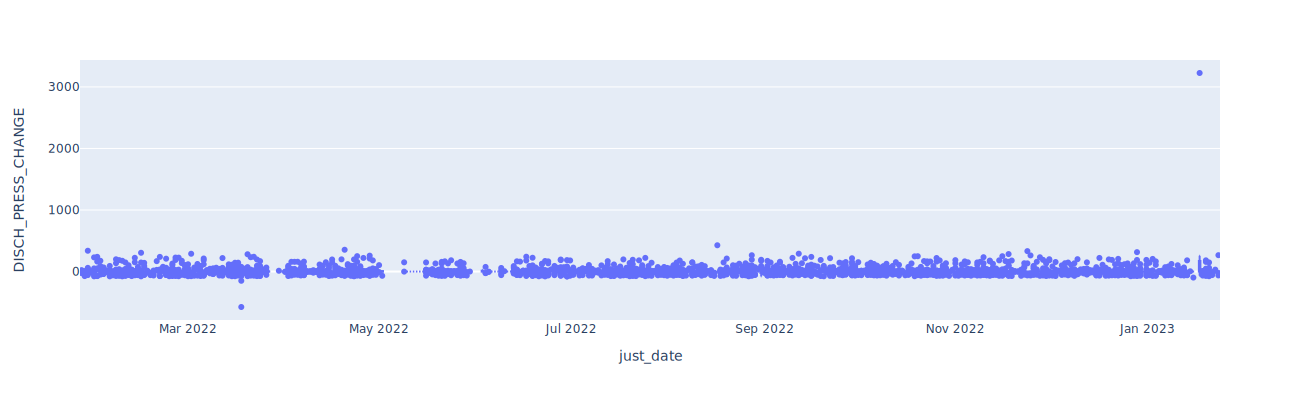

In [7]:
# Create a box plot using Plotly Express with specified width and height
fig = px.box(df_2, x="just_date", y="DISCH_PRESS_CHANGE")

# Update the layout to specify a taller height of 400 pixels and a wider width of 1300 pixels
fig.update_layout(height=400, width=1300)

# Display the plot
fig.show()

### Data Preparation

In [8]:
# Our target variable is 'DISCH_PRESS'
# Extract features and target variable from the dataframe
features = df_2[['DISCH_SUPERHEAT', 'DISCH_TEMP', 'SUCT_PRESS']]
target = df_2['DISCH_PRESS']

# Display the shape of features and target
print("Features shape:", features.shape)
print("Target shape:", target.shape)

# Convert features and target to numpy arrays
features_array = np.array(features)
target_array = np.array(target)

# Split the data into training and testing sets
# Always split the data before applying scaling
X_train, X_test, y_train, y_test = train_test_split(features_array, target_array,
                                                    test_size=0.2,
                                                    random_state=123)
# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Use MinMaxScaler to scale the features
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

Features shape: (8273, 3)
Target shape: (8273,)
X_train shape: (6618, 3)
X_test shape: (1655, 3)
y_train shape: (6618,)
y_test shape: (1655,)


### Build Model

In [9]:
# Build the model architecture
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu'))  # Input layer with 1000 neurons and ReLU activation function
model.add(Dense(500, activation='relu'))  # Hidden layer with 500 neurons and ReLU activation function
model.add(Dense(250, activation='relu'))  # Hidden layer with 250 neurons and ReLU activation function
model.add(Dense(1, activation='linear'))  # Output layer with 1 neuron and linear activation function
model.summary()  # Display the model summary to inspect the architecture

# Compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])  # Use RMSprop optimizer, mean squared error loss, and mean absolute error metric

# Define early stopping callback to prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

# Fit the model to the training data
# Store the training history in 'history' variable to visualize learning curves
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    callbacks=[es],  # Use early stopping callback
                    epochs=5000,
                    batch_size=50,
                    verbose=1)  # Verbosity level set to 1 to display progress during training

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1000)                │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 250)                 │         125,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 630,001 (2.40 MB)

 Trainable params: 630,001 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 58.7622 - mae: 3.6444 - val_loss: 3.2036 - val_mae: 1.7240
Epoch 2/5000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2325 - mae: 1.3459 - val_loss: 0.8533 - val_mae: 0.8234
Epoch 3/5000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1404 - mae: 0.9477 - val_loss: 1.0926 - val_mae: 1.0008
Epoch 4/5000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9087 - mae: 0.8455 - val_loss: 0.5160 - val_mae: 0.6303
Epoch 5/5000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7127 - mae: 0.7505 - val_loss: 0.4453 - val_mae: 0.5924
Epoch 6/5000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6182 - mae: 0.6863 - val_loss: 0.2420 - val_mae: 0.4046
Epoch 7/5000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5285 - mae: 0.6296 - val_loss: 0.4254 - val_mae: 0.5752
Epoch 8/5000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5144 - mae: 0.6303 - val_loss: 0.3513 - val_mae: 0.5085
Epoch 9/5000
133/133 ━━━━━━━━━━━━━━━━━

### Evaluation

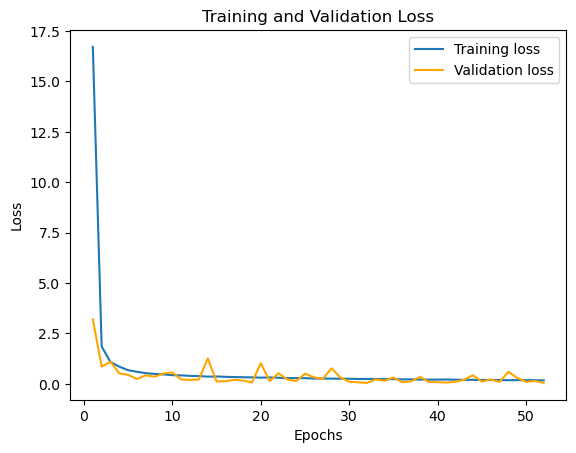

In [10]:
# Visualize training and validation loss by epoch
history_dict = history.history
loss_values = history_dict['loss']  # Training loss values
val_loss_values = history_dict['val_loss']  # Validation loss values
epochs = range(1, len(loss_values) + 1)  # Range of epochs

# Plot training and validation loss
plt.plot(epochs, loss_values, label='Training loss')  # Plot training loss with blue dots
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')  # Plot validation loss with orange line
plt.title('Training and Validation Loss')  # Set title of the plot
plt.xlabel('Epochs')  # Label x-axis as 'Epochs'
plt.ylabel('Loss')  # Label y-axis as 'Loss'
plt.legend()  # Display legend
plt.show()  # Show the plot

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


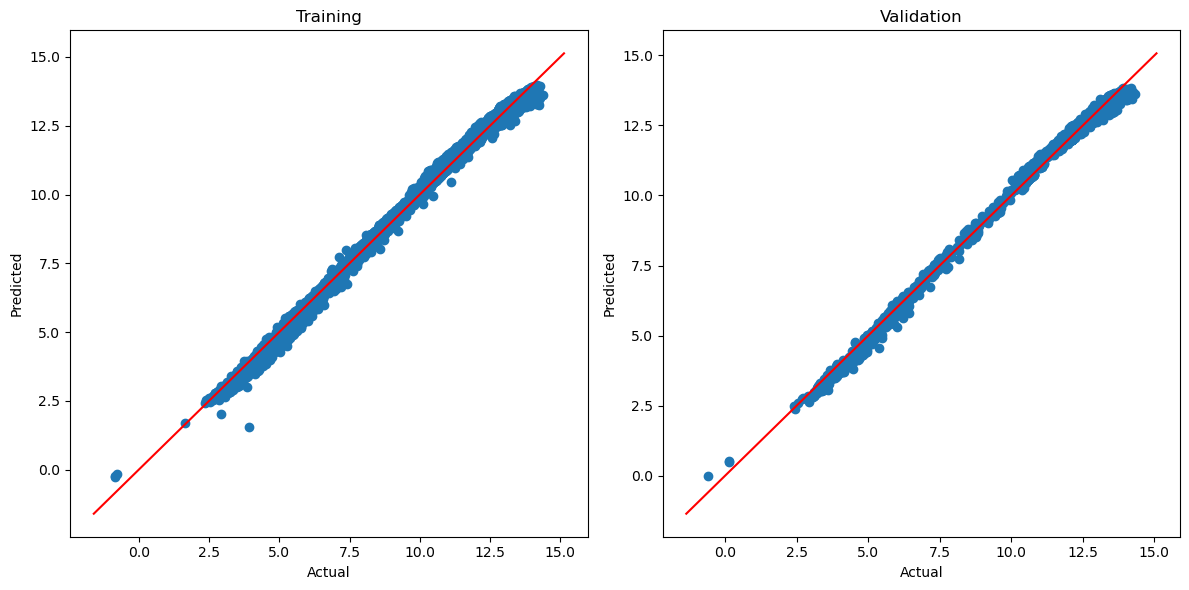

In [11]:
# Scatterplot of actual vs. predicted values with specified dimensions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns with figure size 12x6 inches

# Plot training results
axes[0].scatter(x=y_train, y=model.predict(X_train))  # Plot actual vs. predicted for training data
axes[0].set_xlabel("Actual", fontsize=10)  # Set x-axis label for training plot
axes[0].set_ylabel("Predicted", fontsize=10)  # Set y-axis label for training plot
axes[0].set_title("Training")  # Set title for training plot
# Add 45-degree line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Plot validation results
axes[1].scatter(x=y_test, y=model.predict(X_test))  # Plot actual vs. predicted for validation data
axes[1].set_xlabel("Actual", fontsize=10)  # Set x-axis label for validation plot
axes[1].set_ylabel("Predicted", fontsize=10)  # Set y-axis label for validation plot
axes[1].set_title("Validation")  # Set title for validation plot
# Add 45-degree line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plot
plt.show()

In [12]:
# Calculate and print evaluation metrics
pred = model.predict(X_test)  # Predictions on test data

train_preds = model.predict(X_train)  # Predictions on training data

from sklearn.metrics import mean_absolute_error  # Import mean absolute error metric

# Print mean absolute error for training data
print("Mean Absolute Error (Training):", mean_absolute_error(y_train, train_preds))

# Print mean absolute error for test data
print("Mean Absolute Error (Test):", mean_absolute_error(y_test, pred))

# Print actual vs. predicted values for training data (optional)
print("Actual vs. Predicted (Training):", (y_train, train_preds))

# Print mean absolute error for test data (repeated)
print("Mean Absolute Error (Test):", mean_absolute_error(y_test, pred))

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Absolute Error (Training): 0.16853905458127696
Mean Absolute Error (Test): 0.17234280745614242
Actual vs. Predicted (Training): (array([13.43176431, 13.53619972, 12.29121837, ..., 12.23983909,
       13.63310008, 12.32454033]), array([[13.410297 ],
       [13.4420395],
       [12.497097 ],
       ...,
       [12.432909 ],
       [13.553932 ],
       [12.415836 ]], dtype=float32))
Mean Absolute Error (Test): 0.17234280745614242


In [13]:
# Test the model with input values: DISCH_SUPERHEAT, DISCH_TEMP, SUCT_PRESS
input_values = [[56.003080, 50.664238, 2.269226]]  # Input values for prediction

# Scale the input values using MinMaxScaler and predict
scaled_input = min_max_scaler.transform(input_values)  # Scale input values
predicted_output = model.predict(scaled_input)[0][0]  # Predict the output

# Print the predicted output
print("Predicted Discharge Pressure:", predicted_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Discharge Pressure: 1.2899342


### Save DL Model

In [14]:
# Save the trained model
model.save('./Compressor_Machine.h5')  # Save the model to a file named "Compressor_Machine.h5"

# Save the scaler used for scaling input data
import pickle  # Import pickle module
scalerfile = './scaler.sav'  # Define the file path for saving the scaler
pickle.dump(min_max_scaler, open(scalerfile, 'wb'))  # Use pickle to dump the scaler to the specified file path